## _*Qiskit Chemistry, H2O ground state computation*_

This notebook demonstrates how to use Qiskit Chemistry to compute the ground state energy of a water (H2O) molecule using VQE and UCCSD.

While the molecule has been input below to the driver in xyz format, the Z-matrix format is also support. H2O in Z-matrix format would look like this 
```
H; O 1 1.08; H 2 1.08 1 104.5
```
and is convenient when the goal is to change bond angle, or plot the energy changing distance(s) while preserving the angle.

This notebook has been written to use the PYSCF chemistry driver. 

In [1]:
from qiskit import BasicAer

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.optimizers import SLSQP

from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType 
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

Couldn't find cython int routine
Couldn't find cython int routine


First we create and run a driver to produce our molecule object. The molecule object holds data from the drivers in a common way so it can then be used independently of which specific driver created it.

And let's print some of fields it has. You can refer to qiskit.aqua.qmolecule.py for more information or look at the API documentation.

In [2]:
driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0',
                     unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print('Hartree-Fock energy: {}'.format(molecule.hf_energy))
print('Nuclear repulsion energy: {}'.format(molecule.nuclear_repulsion_energy))
print('Number of molecular orbitals: {}'.format(molecule.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule.num_alpha))
print('Number of beta electrons: {}'.format(molecule.num_beta))

Hartree-Fock energy: -74.9629466565383
Nuclear repulsion energy: 9.193913160623385
Number of molecular orbitals: 7
Number of alpha electrons: 5
Number of beta electrons: 5


We now need to create a qubit operator as input to compute the ground state energy. The Hamilitonian object can be used. This wraps a `FermionicOperator` class, which can be used directly but entails more steps. Other tutorials here show FermionicOperator being used.

The Hamiltonian class not only gives us a qubit operator for the main Hamiltonian but also auxilliary operators including dipole operators and others to measure spin and num particles. The algorithm, if it supports aux_ops, which ExactEignesolver and VQE both do, will evaluate these at the ground state where the minimum energy is found.

In [3]:
core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=True, freeze_core=True)
qubit_op, aux_ops = core.run(molecule)

print(qubit_op)

Representation: paulis, qubits: 10, size: 551


We now pass these to the ExactEigensolver and run it to produce a result. This result will include the computed electronic part of the ground state energy. We can pass this result back to the Hamiltonian object from above and it will combine it with values it stored such as the frozen core energy to form a complete result for the molecule. As can be seen this matches the result from the declarative approach above.

Note: the num particles printed here is that which is observed from the spin operator that is in the aux_ops. It says 8 which matches what we expect; the molecule has 10 (5 alpha and 5 beta) but the operator was left with 8 after we took away 2 from freezing the core. The molecule has a core_orbitals property which lists the orbitals comprising the core ones that can be frozen so we can easily figure how many electrons that is (2 per orbital in that list).

In [4]:
ee = ExactEigensolver(qubit_op, aux_operators=aux_ops)
algo_result = ee.run()
result = core.process_algorithm_result(algo_result)
for line in result[0]:
    print(line)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.206272446428
  - computed part:      -23.544497240436
  - frozen energy part: -60.661775205992
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012359285805
  Measured:: Num particles: 8.000, S: 0.000, M: 0.00000
 
=== DIPOLE MOMENT ===
 
* Electronic dipole moment (a.u.): [0.0  1.57867263  0.0]
  - computed part:      [0.0  1.57778798  0.0]
  - frozen energy part: [0.0  0.00088465  0.0]
  - particle hole part: [0.0  0.0  0.0]
~ Nuclear dipole moment (a.u.): [0.0  2.21475902  0.0]
> Dipole moment (a.u.): [0.0  0.63608639  0.0]  Total: 0.63608639
               (debye): [0.0  1.61677018  0.0]  Total: 1.61677018


#### Using VQE

Here we will start with the qubit operator that we computed above. We need to setup an optimizer, variational form and initial state for use with VQE.

The variational form and UCCSD are a little more complex since they need information about numbers of orbitals and numbers of electrons, as well as what qubit mapping etc was used for the qubit operator. However we have some help from the Hamiltonian class that we can use (which internally is what the declarative form takes advantage of too). 

Note: If you use FermionicOperator directly to make a qubit operator then you need to keep track of electrons removed etc. The molecule object from the driver has the original values but if you freeze out orbitals then the electrons remaining in the operator is what is required.

In [5]:
init_state = HartreeFock(num_qubits=qubit_op.num_qubits, 
                         num_orbitals=core._molecule_info['num_orbitals'],
                         num_particles=core._molecule_info['num_particles'],
                         qubit_mapping=core._qubit_mapping,
                         two_qubit_reduction=core._two_qubit_reduction)

var_form = UCCSD(num_qubits=qubit_op.num_qubits,
                 depth=1,
                 num_orbitals=core._molecule_info['num_orbitals'], 
                 num_particles=core._molecule_info['num_particles'],
                 qubit_mapping=core._qubit_mapping,
                 two_qubit_reduction=core._two_qubit_reduction, 
                 initial_state=init_state)

optimizer = SLSQP(maxiter=2500)

# setup backend on which we will run
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend)

vqe = VQE(qubit_op, var_form, optimizer)
algo_result = vqe.run(quantum_instance)
lines, result = core.process_algorithm_result(algo_result)

print('Ground state energy: {}'.format(result['energy']))

for line in lines:
    print(line)

Ground state energy: -75.01225859170299
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.206171752326
  - computed part:      -23.544396546334
  - frozen energy part: -60.661775205992
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012258591703


Internally the core, when processing the algorithm result, stores the result dictionary from the algorithm under the `algorithm_retvals` key. We used this above in declarative approach, to get the eval count, and since we process the result the same way here, using the core, we can do this here too. But here we have direct access to the algorithm result since we ran it. Hence we can access the count directly from the above algo_result. To show these are the same they are both printed below.

In [6]:
print('Actual VQE evaluations taken: {}'.format(result['algorithm_retvals']['eval_count']))

print('Actual VQE evaluations taken: {}'.format(algo_result['eval_count']))

Actual VQE evaluations taken: 666
Actual VQE evaluations taken: 666


#### Z-matrix format

Z-matrix was mentioned in the introduction. Lets show it in use in a quick final example here. We'll use ExactEigensolver as the goal here is just to show the technique. We will keep the bond angle between the Hydrogen atoms and Oxygen constant while varying the interatomic distance of one the Hydrogen atoms. This is simple to do in Z-matrix format, though can of course be done using xyz format but that needs more work to compute the coordinates each time.

In [7]:
import numpy as np
import pylab

h2o = 'H; O 1 1.08; H 2 {} 1 104.5'

distances = [x * 0.01 + 1.00 for x in range(17)]
energies = np.empty(len(distances))

for i, distance in enumerate(distances):
    driver = PySCFDriver(h2o.format(distance), basis='sto3g')
    qmolecule = driver.run()
    operator =  Hamiltonian(freeze_core=True)
    qubit_op, aux_ops = operator.run(qmolecule)
    result = ExactEigensolver(qubit_op).run()
    lines, result = operator.process_algorithm_result(result)
    result['printable'] = lines
    energies[i] = result['energy']

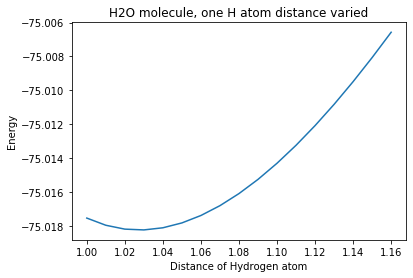

In [8]:
pylab.plot(distances, energies)
pylab.xlabel('Distance of Hydrogen atom')
pylab.ylabel('Energy')
pylab.title('H2O molecule, one H atom distance varied');